In [73]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
pd.set_option("display.max_rows", 300)

In [4]:
cas_data = pd.read_excel("06 - CAS Predictive Modeling Case Competition- Dataset.xlsx")

In [5]:
cas_data

,student_id,name,class,study,gpa,greek,off_campus,distance_to_campus,gender,sprinklered,coverage,claim_id,amount,risk_tier,holdout
0,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.000000,Male,True,Additional Living Expense,0,0.0,2,False
1,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.000000,Male,True,Guest Medical,0,0.0,2,False
2,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.000000,Male,True,Liability,0,0.0,2,False
3,1,"Saiz, Leslie",Junior,Humanities,1.203913,Non-greek,On campus,0.000000,Male,True,Personal Property,0,0.0,2,False
4,2,"Reddy, Dawna",Junior,Science,0.609616,Non-greek,On campus,0.000000,Female,True,Additional Living Expense,0,0.0,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40066,9999,"Duncan, Justin",Freshman,Business,2.508244,Greek,On campus,0.000000,Female,True,Personal Property,0,0.0,1,False
40067,10000,"Darrough, Gedion",Grad student,Science,0.108804,Non-greek,Off campus,1.972557,Female,True,Additional Living Expense,0,0.0,3,False
40068,10000,"Darrough, Gedion",Grad student,Science,0.108804,Non-greek,Off campus,1.972557,Female,True,Guest Medical,0,0.0,3,False
40069,10000,"Darrough, Gedion",Grad student,Science,0.108804,Non-greek,Off campus,1.972557,Female,True,Liability,0,0.0,3,True


In [32]:
cas_data.columns

Index(['student_id', 'name', 'class', 'study', 'gpa', 'greek', 'off_campus',
       'distance_to_campus', 'gender', 'sprinklered', 'coverage', 'claim_id',
       'amount', 'risk_tier', 'holdout', 'study_category', 'is_humanities',
       'is_science', 'is_business', 'is_other'],
      dtype='object')

In [28]:
def test(df):
    flag = True
    for _, row in df.iterrows():
        if row.iloc[7] == 0 and row.iloc[6] == "Off campus":
            flag = False
        if not flag:
            return flag
    return flag
test(cas_data)

True

We can ignore the off and on campus label, since any student on capus alreayd has distance == 0, and no off campus has distance == 0

In [6]:
cas_data.shape

(40071, 15)

In [9]:
print(cas_data["gpa"].mean())

2.3309177896137605


In [10]:
print(cas_data["gpa"].max())

3.984116605


In [11]:
print(cas_data["gpa"].min())

0.041502616


In [13]:
print(cas_data["distance_to_campus"].mean()) # Assume km

1.3914807371542512


In [14]:
print(cas_data["distance_to_campus"].max()) # The closest is 0

29.91104309


In [27]:
scaler = StandardScaler()

In [29]:
cas_data["risk_tier"].max()

3

In [6]:
x = cas_data["amount"]

In [9]:
x.index

RangeIndex(start=0, stop=40071, step=1)

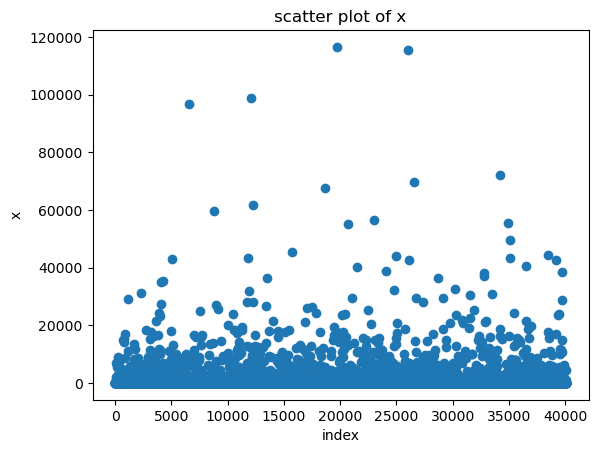

In [8]:
plt.figure()
plt.scatter(x.index, x)
plt.xlabel("index")
plt.ylabel("x")
plt.title("scatter plot of x")
plt.show()

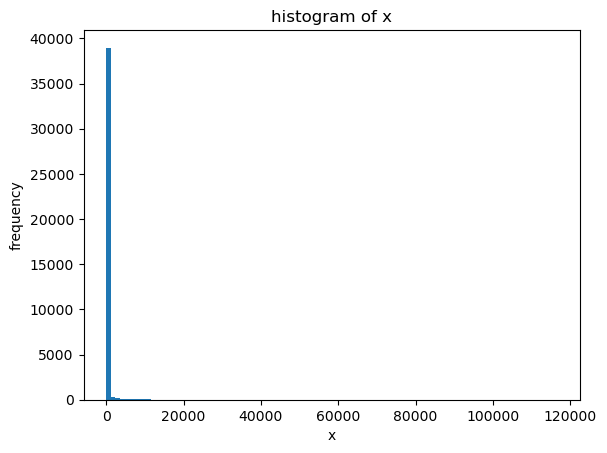

In [15]:
plt.figure()
plt.hist(x, bins=100)
plt.xlabel("x")
plt.ylabel("frequency")
plt.title("histogram of x")
plt.show()

## Determining base (average) rate for Personal Property Protection

Average of non-outliers costs' will be considered. The average cost over a period of time, + the average profit of insurance companies will give us a base rate.

In [16]:
avg_payout = cas_data["amount"].mean()

In [17]:
avg_payout

np.float64(212.49132853175792)

In [8]:
cas_data["study"].unique()

array(['Humanities', 'Science', 'Business', 'Other'], dtype=object)

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('gpa ~ C(study)', data=cas_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

In [23]:
cas_data.groupby('study')['gpa'].mean()

study
Business      2.333906
Humanities    2.352229
Other         2.311046
Science       2.326564
Name: gpa, dtype: float64

So average gpa is different significantly, and humanities has the biggest average gpa, while other has the lowest. Therefore, to avoid attribuing high risk to "other" due to major difficulty, the risk calculation should take this difference into account

# We build the premium pricing model

We divide the data into the 4 different models:

In [137]:
# Personal Property Protection (ppp_cas)
ppp_cas = cas_data[cas_data["coverage"] == "Personal Property"]

In [138]:
# Additional Living Expenses (ale_cas)
ale_cas = cas_data[cas_data["coverage"] == "Additional Living Expense"]

In [139]:
# Liability Protection (lp_cas)
lp_cas = cas_data[cas_data["coverage"] == "Liability"]

In [140]:
# Guest Medical Protection (gmp_cas)
gmp_cas = cas_data[cas_data["coverage"] == "Guest Medical"]

## For each one, we make a predictive model using Tweedle Generalized Linear Model

#### Personal Property Protection

In [109]:
train_ppp = ppp_cas[ppp_cas['holdout'] == True]
test_ppp = ppp_cas[ppp_cas['holdout'] == False]

Next, we drop columns since they have no dignificant importance in risk

In [110]:
# We drop off campus too due to our findings at the top
drop_col = ['student_id', 'name', 'claim_id', 'holdout', 'off_campus', "coverage"]

train_ppp = train_ppp.drop(columns=drop_col)
test_ppp  = test_ppp.drop(columns=drop_col)

In [111]:
categorical = ['study', 'class', 'gender', 'greek', 'sprinklered']

In [112]:
train_ppp_encoded = pd.get_dummies(train_ppp, columns=categorical, drop_first=True)
test_ppp_encoded  = pd.get_dummies(test_ppp,  columns=categorical, drop_first=True)

# Align columns (VERY important)
test_ppp_encoded = test_ppp_encoded.reindex(columns=train_ppp_encoded.columns, fill_value=0)
train_ppp_encoded.head(5)

,gpa,distance_to_campus,amount,risk_tier,study_Humanities,study_Other,study_Science,class_Grad student,class_Junior,class_Senior,class_Sophomore,gender_Female,gender_Male,gender_Other,greek_Non-greek,sprinklered_True
39,1.309350,0.000000,0.0,1,False,False,False,False,False,False,False,False,False,True,False,True
51,3.133929,0.000000,0.0,1,False,False,True,False,False,False,False,False,True,False,True,False
55,1.705162,0.000000,0.0,1,True,False,False,False,False,False,False,False,True,False,True,False
119,3.147208,0.000000,0.0,1,True,False,False,False,False,False,False,True,False,False,True,True
123,1.660514,0.462273,0.0,3,False,False,True,False,False,True,False,True,False,False,True,False


In [113]:
train_ppp_encoded['distance_log'] = np.log1p(train_ppp_encoded['distance_to_campus'])
test_ppp_encoded['distance_log'] = np.log1p(test_ppp_encoded['distance_to_campus'])

In [114]:
bools = train_ppp_encoded.select_dtypes(include='bool').columns
bools = ['study_Humanities', 'study_Other', 'study_Science',
       'class_Grad student', 'class_Junior', 'class_Senior', 'class_Sophomore',
       'gender_Female', 'gender_Male', 'gender_Other', 'greek_Non-greek',
       'sprinklered_True']
print(bools)

['study_Humanities', 'study_Other', 'study_Science', 'class_Grad student', 'class_Junior', 'class_Senior', 'class_Sophomore', 'gender_Female', 'gender_Male', 'gender_Other', 'greek_Non-greek', 'sprinklered_True']


In [115]:
train_ppp_encoded[bools] = train_ppp_encoded[bools].astype(int)
test_ppp_encoded[bools] = test_ppp_encoded[bools].astype(int)

In [117]:
train_ppp_encoded["interaction_greek"] = train_ppp_encoded['greek_Non-greek'] * train_ppp_encoded['distance_log']

In [118]:
test_ppp_encoded["interaction_greek"] = test_ppp_encoded['greek_Non-greek'] * test_ppp_encoded['distance_log']

In [123]:
train_ppp_encoded = train_ppp_encoded[train_ppp_encoded['amount'] > 0]
test_ppp_encoded = test_ppp_encoded[test_ppp_encoded['amount'] > 0]

X_ppp_train = train_ppp_encoded.drop(columns=['amount'])
y_ppp_train = train_ppp_encoded['amount']

X_ppp_test = test_ppp_encoded.drop(columns=['amount'])
y_ppp_test = test_ppp_encoded['amount']

In [124]:
model = sm.GLM(
    y_ppp_train,
    sm.add_constant(X_ppp_train),
    family=sm.families.Tweedie(
        var_power=1.1,
        link=sm.families.links.log()
    )
)

results = model.fit()

/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [125]:
y_ppp_pred = results.predict(sm.add_constant(X_ppp_test))

In [126]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_ppp_test, y_ppp_pred)
print(mae)

514.4876827613136


In [127]:
real_mean = y_ppp_test.mean()
real_mean

np.float64(1049.4313901018475)

In [128]:
print (mae / real_mean)

0.49025375800068505


## Additional Living Expenses 

In [141]:
train_ale = ale_cas[ale_cas['holdout'] == True]
test_ale = ale_cas[ale_cas['holdout'] == False]

In [142]:
# We drop off campus too due to our findings at the top
drop_col = ['student_id', 'name', 'claim_id', 'holdout', 'off_campus', "coverage"]

train_ale = train_ale.drop(columns=drop_col)
test_ale  = test_ale.drop(columns=drop_col)

In [143]:
train_ale_encoded = pd.get_dummies(train_ale, columns=categorical, drop_first=True)
test_ale_encoded  = pd.get_dummies(test_ale,  columns=categorical, drop_first=True)

# Align columns (VERY important)
test_ale_encoded = test_ale_encoded.reindex(columns=train_ale_encoded.columns, fill_value=0)
train_ale_encoded.head(5)

,gpa,distance_to_campus,amount,risk_tier,study_Humanities,study_Other,study_Science,class_Grad student,class_Junior,class_Senior,class_Sophomore,gender_Female,gender_Male,gender_Other,greek_Non-greek,sprinklered_True
8,3.073385,0.223942,0.0,2,False,False,False,False,True,False,False,True,False,False,True,False
24,3.243341,0.000000,0.0,2,False,False,True,False,True,False,False,True,False,False,True,False
60,0.746324,0.000000,0.0,1,False,False,False,False,False,False,True,False,True,False,True,True
85,1.874571,0.000000,0.0,3,False,False,True,False,False,True,False,False,True,False,False,True
105,2.582975,0.000000,0.0,1,False,False,False,False,False,False,True,False,True,False,False,True


In [144]:
train_ale_encoded['distance_log'] = np.log1p(train_ale_encoded['distance_to_campus'])
test_ale_encoded['distance_log'] = np.log1p(test_ale_encoded['distance_to_campus'])

In [145]:
train_ale_encoded[bools] = train_ale_encoded[bools].astype(int)
test_ale_encoded[bools] = test_ale_encoded[bools].astype(int)

In [146]:
train_ale_encoded["interaction_greek"] = train_ale_encoded['greek_Non-greek'] * train_ale_encoded['distance_log']
test_ale_encoded["interaction_greek"] = test_ale_encoded['greek_Non-greek'] * test_ale_encoded['distance_log']

In [147]:
train_ale_encoded = train_ale_encoded[train_ale_encoded['amount'] > 0]
test_ale_encoded = test_ale_encoded[test_ale_encoded['amount'] > 0]

X_ale_train = train_ale_encoded.drop(columns=['amount'])
y_ale_train = train_ale_encoded['amount']

X_ale_test = test_ale_encoded.drop(columns=['amount'])
y_ale_test = test_ale_encoded['amount']

model = sm.GLM(
    y_ale_train,
    sm.add_constant(X_ale_train),
    family=sm.families.Tweedie(
        var_power=1.1,
        link=sm.families.links.log()
    )
)

results = model.fit()

y_ale_pred = results.predict(sm.add_constant(X_ale_test))
mae = mean_absolute_error(y_ale_test, y_ale_pred)
print(mae)

real_mean = y_ale_test.mean()
real_mean
print (mae / real_mean)


2673.8761129826757
0.49710137677013827


/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## Liability Protection

In [181]:
train_lp = lp_cas[lp_cas['holdout'] == True]
test_lp = lp_cas[lp_cas['holdout'] == False]

# We drop off campus too due to our findings at the top
drop_col = ['student_id', 'name', 'claim_id', 'holdout', 'off_campus', "coverage"]

train_lp = train_lp.drop(columns=drop_col)
test_lp  = test_lp.drop(columns=drop_col)

train_lp_encoded = pd.get_dummies(train_lp, columns=categorical, drop_first=True)
test_lp_encoded  = pd.get_dummies(test_lp,  columns=categorical, drop_first=True)

# Align columns (VERY important)
test_lp_encoded = test_lp_encoded.reindex(columns=train_lp_encoded.columns, fill_value=0)

train_lp_encoded['distance_log'] = np.log1p(train_lp_encoded['distance_to_campus'])
test_lp_encoded['distance_log'] = np.log1p(test_lp_encoded['distance_to_campus'])

train_lp_encoded[bools] = train_lp_encoded[bools].astype(int)
test_lp_encoded[bools] = test_lp_encoded[bools].astype(int)

train_lp_encoded["interaction_greek"] = train_lp_encoded['greek_Non-greek'] * train_lp_encoded['distance_log']
test_lp_encoded["interaction_greek"] = test_lp_encoded['greek_Non-greek'] * test_lp_encoded['distance_log']


X_lp_train = train_lp_encoded.drop(columns=['amount'])
y_lp_train = train_lp_encoded['amount']

X_lp_test = test_lp_encoded.drop(columns=['amount'])
y_lp_test = test_lp_encoded['amount']

model = sm.GLM(
    y_lp_train,
    sm.add_constant(X_lp_train),
    family=sm.families.Tweedie(
        var_power=1,
        link=sm.families.links.log()
    )
)

results = model.fit()

y_lp_pred = results.predict(sm.add_constant(X_lp_test))
mae = mean_absolute_error(y_lp_test, y_lp_pred)
print(mae)

real_mean = y_lp_test.mean()
print (mae / real_mean)




167.92622922311165
2.4191839888453472


/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: divide by zero encountered in log
  endog * np.log(endog / mu) + (mu - endog))
/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: invalid value encountered in multiply
  endog * np.log(endog / mu) + (mu - endog))


## Guest Medical Coverage

In [172]:
train_gmp = gmp_cas[gmp_cas['holdout'] == True]
test_gmp = gmp_cas[gmp_cas['holdout'] == False]

# We drop off campus too due to our findings at the top
drop_col = ['student_id', 'name', 'claim_id', 'holdout', 'off_campus', "coverage"]

train_gmp = train_gmp.drop(columns=drop_col)
test_gmp  = test_gmp.drop(columns=drop_col)

train_gmp_encoded = pd.get_dummies(train_gmp, columns=categorical, drop_first=True)
test_gmp_encoded  = pd.get_dummies(test_gmp,  columns=categorical, drop_first=True)

# Align columns (VERY important)
test_gmp_encoded = test_gmp_encoded.reindex(columns=train_gmp_encoded.columns, fill_value=0)

train_gmp_encoded['distance_log'] = np.log1p(train_gmp_encoded['distance_to_campus'])
test_gmp_encoded['distance_log'] = np.log1p(test_gmp_encoded['distance_to_campus'])

train_gmp_encoded[bools] = train_gmp_encoded[bools].astype(int)
test_gmp_encoded[bools] = test_gmp_encoded[bools].astype(int)

train_gmp_encoded["interaction_greek"] = train_gmp_encoded['greek_Non-greek'] * train_gmp_encoded['distance_log']
test_gmp_encoded["interaction_greek"] = test_gmp_encoded['greek_Non-greek'] * test_gmp_encoded['distance_log']

train_gmp_encoded = train_gmp_encoded[train_gmp_encoded['amount'] > 0]
test_gmp_encoded = test_gmp_encoded[test_gmp_encoded['amount'] > 0]

X_gmp_train = train_gmp_encoded.drop(columns=['amount'])
y_gmp_train = train_gmp_encoded['amount']

X_gmp_test = test_gmp_encoded.drop(columns=['amount'])
y_gmp_test = test_gmp_encoded['amount']

model = sm.GLM(
    y_gmp_train,
    sm.add_constant(X_gmp_train),
    family=sm.families.Tweedie(
        var_power=1.7,
        link=sm.families.links.log()
    )
)

results = model.fit()

y_gmp_pred = results.predict(sm.add_constant(X_gmp_test))
mae = mean_absolute_error(y_gmp_test, y_gmp_pred)
print(mae)

real_mean = y_gmp_test.mean()
print (mae / real_mean)

12520.952799084836
0.7135245375781667


/opt/conda/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


## Expected loss for each:

In [186]:
ppp = ppp_cas["amount"].mean()
ale = ale_cas["amount"].mean()
lp = lp_cas["amount"].mean()
gmp = gmp_cas["amount"].mean()


np.float64(386.90044949791087)

## Pricing = E(payout to policyholder)*(1 + risk_aversion*(relative_mae) + base rate
We assume a risk_aversion of 0.3 according to industry standards

In [191]:
# For ppp, premium is:
premium_ppp = ppp * (1 + 0.3 * 0.49025375800068505)
# For ale, premium is:
premium_ale = ale * (1 + 0.3 * 0.49710137677013827)
# For lp, premium is:
premium_lp = lp * (1 + 0.3 * 2.4191839888453472)
# For gmp, premium is:
premium_gmp = gmp * (1+ 0.3 * 0.7135245375781667)